#  Qualifying Human Activity
***Reynaldo Vazquez***  
***April, 2018***

## Tests various classification algorithms on accelerometer data to qualify how individuals perform weight-lifting exercises

<img src="media/bicep_emoji.png" style="width:180px;height:180px;padding:5px" align="right">


The best performing algorithms are a K-Nearest and a GBM Classifier with over **99.9% accuracy, precision, recall, and F1** on 5 classes. Both algorithms train and make predictions fast.

Other classifiers reported here include a Multilayer Perceptron Network and a Random Forest, both attain over 99% accuracy as well.

The dataset comes from Veloso et al., (2013) and it contains data from accelerometers on the belt, forearm, arm, and dumbbell from 6 individuals. The individuals performed one set of 10 repetitions of the unilateral dumbbell biceps curl in five different ways: (A) correctly; (B) throwing the elbows to the front; (C) lifting the dumbbell only halfway; (D) lowering the dumbbell only halfway; and (E) throwing the hips to the front. The original dataset and more information can be found [here](http://groupware.les.inf.puc-rio.br/har). The direct link to download the data is found [here](http://groupware.les.inf.puc-rio.br/static/WLE/WearableComputing_weight_lifting_exercises_biceps_curl_variations.csv). 

Subject identities and a few other variables were strapped from the original dataset to prevent data leakeage.

### Packages

In [1]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
import sklearn.neural_network as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from cm_heat_plots import *
import time
%matplotlib inline

### Data

In [2]:
# Original dataset name: WearableComputing_weight_lifting_exercises_biceps_curl_variations.csv
df = pd.read_csv('biceps_curl_variations.csv', low_memory=False)
print("Original data shape:", df.shape)

Original data shape: (39242, 159)


In [3]:
## Drop irrelevant first columns (they contain subject ID and record dates)
df.drop(df.iloc[:, 0:6], inplace=True, axis=1)

#### Manage NaNs
A great number of culumns contain excessive NaNs, although they typically correspond to statistics. All columns with more than 50 percent NaN will be dropped.

After dropping these columns, there remains 1 single row containing a NaN. It will be removed.

Covariance, low variance, and normalizations for sensitive specifications will be handled with PCA reduction and whitening.

In [4]:
threshold = df.shape[0]*0.5
nan_counts = df.isnull().sum()
keep_cols = nan_counts[nan_counts < threshold].index
data = df[keep_cols]
data = data.dropna()
print("Shape of data to be used:", data.shape)

Shape of data to be used: (39241, 53)


In [5]:
data = data.sort_values(by=['classe']).reset_index()

In [6]:
X = data.loc[:, data.columns != 'classe']
Y = data['classe']

#### Codify Y  labels

In [7]:
classes = Y.unique()
Y_coded = Y.astype("category", pd.api.types.CategoricalDtype(categories = 
                                                        classes)).cat.codes
classes_dict = dict(enumerate(classes))
print("Classes:")
print(", ".join(classes))

Classes:
A, B, C, D, E


In [8]:
class_description = ["correctly", 
    "throwing the elbows to the front", 
    "lifting the dumbbell only halfway", 
   "lowering the dumbbell only halfway",
    "throwing the hips to the front"]

In [9]:
for label, label_class in classes_dict.items():
    print("Number of class ",  label_class + ": \"" + class_description[label] + 
          "\"" + " examples --", sum(Y_coded == label))

Number of class  A: "correctly" examples -- 11158
Number of class  B: "throwing the elbows to the front" examples -- 7593
Number of class  C: "lifting the dumbbell only halfway" examples -- 6844
Number of class  D: "lowering the dumbbell only halfway" examples -- 6432
Number of class  E: "throwing the hips to the front" examples -- 7214


In [10]:
reference = pd.DataFrame({'Class': classes, 'Description': class_description})
ref_print = reference.to_string(index=False)

#### Split into train and test sets. Y_train, Y_test will be used throughout, while X_all_train, X_all_test will be further transformed (using PCA dimensionality reduction) to use in some specifications.

In [11]:
X_all_train, X_all_test, Y_train, Y_test = train_test_split(X ,Y_coded, test_size=4000,
                                                    random_state=3)

#### Reduce features dimension with PCA, whiten.

In [12]:
pca30_dec = decomposition.PCA(n_components = 30, whiten = True).fit(X_all_train)
X_pca30_train = pca30_dec.transform(X_all_train)
X_pca30_test = pca30_dec.transform(X_all_test)

#### Training and reporting function
Will train and return the trained specified model. Will print model preformance metrics.

In [13]:
def run_model(X_train, Y_train, X_test, Y_test, model):
    """
    Trains the specified model, calculates predictions, and returns and prints the
    classification report and accuracy metric.
    """
    print("Model:", str(model).split("(")[0], "\n")
    start_time = time.time()
    trained_model = model.fit(X_train, Y_train)
    elapsed_time = time.time() - start_time
    predicted_Y_test = trained_model.predict(X_test)
    predicted_Y_test = np.rint(predicted_Y_test)   ## Required by Random Forest
    predicted_Y_train = trained_model.predict(X_train)
    predicted_Y_train = np.rint(predicted_Y_train) ## ibid
    print("Classification report on test set \n")
    pred_activity = [classes_dict[label] for label in predicted_Y_test]
    actual_activity = [classes_dict[label] for label in Y_test]
    report = classification_report(pred_activity, actual_activity)
    train_acc = accuracy_score(predicted_Y_train, Y_train)
    test_acc =accuracy_score(predicted_Y_test, Y_test)
    print(report)
    print("Train Accuracy =", str(format(train_acc, '.3f')))
    print("Test Accuracy  =", str(format(test_acc, '.3f')))
    print("Training time:", int(elapsed_time), "seconds")
    return trained_model, report

### K-Nearest Neighbors

In [14]:
knn = KNeighborsClassifier(n_neighbors=1, p = 1)
knn_trained, knn_report = run_model(X_all_train, Y_train, X_all_test, Y_test, knn)

Model: KNeighborsClassifier 

Classification report on test set 

             precision    recall  f1-score   support

          A       1.00      1.00      1.00      1175
          B       1.00      1.00      1.00       766
          C       1.00      1.00      1.00       670
          D       1.00      1.00      1.00       639
          E       1.00      1.00      1.00       750

avg / total       1.00      1.00      1.00      4000

Train Accuracy = 1.000
Test Accuracy  = 1.000
Training time: 0 seconds


### Multilayer Perceptron Neural Network

In [15]:
mlp =  nn.MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, 
                            alpha=.0001, solver='adam', tol=1e-5, random_state=1,
                            learning_rate_init=.0005, beta_1 = 0.9,
                            beta_2 = 0.99) 
mlp_trained, mlp_report = run_model(X_pca30_train, Y_train, X_pca30_test, Y_test, mlp)

Model: MLPClassifier 

Classification report on test set 

             precision    recall  f1-score   support

          A       1.00      1.00      1.00      1178
          B       0.99      1.00      1.00       765
          C       0.99      0.99      0.99       665
          D       0.99      0.99      0.99       638
          E       1.00      0.99      0.99       754

avg / total       0.99      0.99      0.99      4000

Train Accuracy = 0.999
Test Accuracy  = 0.995
Training time: 41 seconds


### Random Forest

In [16]:
rf = RandomForestRegressor(n_estimators=30, random_state = 1, bootstrap = False, max_features='sqrt')
rf_trained, rf_report = run_model(X_all_train, Y_train, X_all_test, Y_test, rf)

Model: RandomForestRegressor 

Classification report on test set 

             precision    recall  f1-score   support

          A       1.00      1.00      1.00      1174
          B       1.00      1.00      1.00       766
          C       1.00      1.00      1.00       673
          D       1.00      1.00      1.00       639
          E       1.00      1.00      1.00       748

avg / total       1.00      1.00      1.00      4000

Train Accuracy = 1.000
Test Accuracy  = 0.998
Training time: 7 seconds


### Gradient Boosting

In [17]:
gbm = GradientBoostingClassifier(learning_rate=0.8, n_estimators=100, max_depth=4)
gbm_trained, gbm_report = run_model(X_all_train, Y_train, X_all_test, Y_test, gbm)

Model: GradientBoostingClassifier 

Classification report on test set 

             precision    recall  f1-score   support

          A       1.00      1.00      1.00      1175
          B       1.00      1.00      1.00       767
          C       1.00      1.00      1.00       670
          D       1.00      1.00      1.00       640
          E       1.00      1.00      1.00       748

avg / total       1.00      1.00      1.00      4000

Train Accuracy = 1.000
Test Accuracy  = 1.000
Training time: 36 seconds


### Prediction Time and Confusion Matrices

In [18]:
def predict_and_time(trained_model, X):
    """
    Calculates predictions and prints the time elapsed to make the predictions
    Args:
        trained_model: a trained (sklearn) model 
        X: a set of features
    Returns:
        predictions
    """
    model_name = str(trained_model).split("(")[0]
    start_time = time.time()
    predictions = trained_model.predict(X)
    elapsed_time = time.time() - start_time
    predictions = np.rint(predictions)   # Required by Random Forest
    print("Time to calculate", X.shape[0], "predictions with", model_name, "model:", 
          str(format(elapsed_time, '.4f')), "seconds")
    return predictions

In [19]:
knn_predictions = predict_and_time(knn_trained, X_all_test)

Time to calculate 4000 predictions with KNeighborsClassifier model: 0.1499 seconds


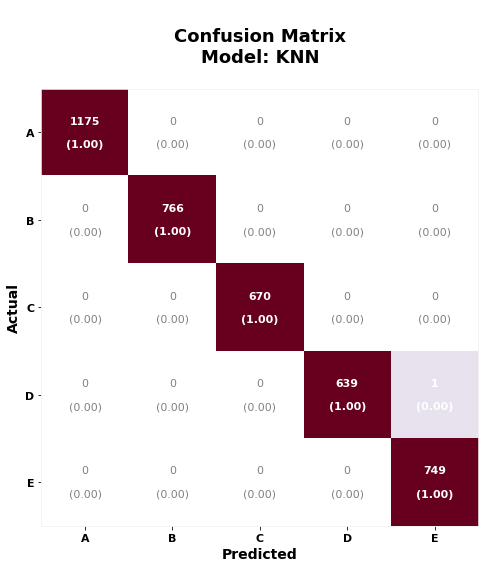

In [20]:
cm_knn = confusion_matrix(Y_test, knn_predictions)
heated_confusion_matrix(cm = cm_knn, labels = classes, cmap = plt.cm.PuRd, 
                        contrast = 3, model_name = "KNN")

In [21]:
print("Reference\n")
print(ref_print)

Reference

Class                         Description
   A                           correctly
   B    throwing the elbows to the front
   C   lifting the dumbbell only halfway
   D  lowering the dumbbell only halfway
   E      throwing the hips to the front


In [22]:
gbm_predictions = predict_and_time(gbm_trained, X_all_test)

Time to calculate 4000 predictions with GradientBoostingClassifier model: 0.0232 seconds


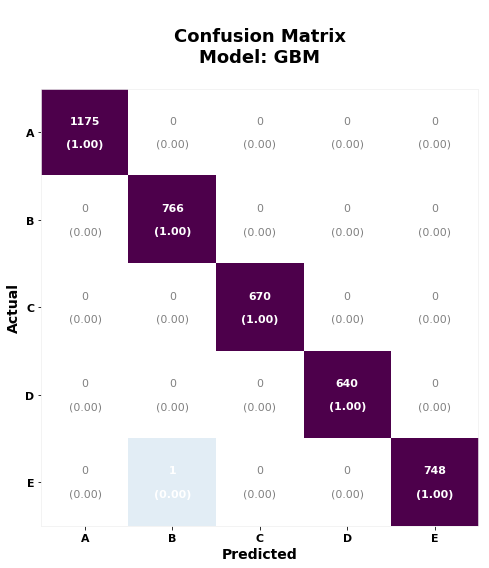

In [23]:
cm_gbm = confusion_matrix(Y_test, gbm_predictions)
heated_confusion_matrix(cm = cm_gbm, labels = classes, cmap = plt.cm.BuPu, 
                        contrast = 3, model_name = "GBM", save_fig = True)

In [24]:
rf_predictions = predict_and_time(rf_trained, X_all_test)

Time to calculate 4000 predictions with RandomForestRegressor model: 0.0305 seconds


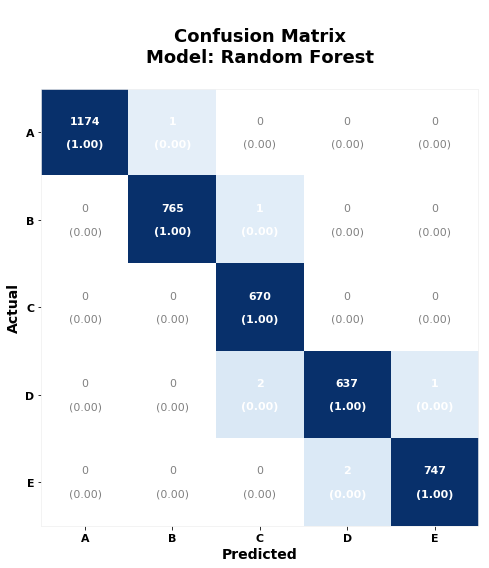

In [25]:
cm_rf = confusion_matrix(Y_test, rf_predictions)
heated_confusion_matrix(cm = cm_rf, labels = classes, cmap = plt.cm.Blues, 
                           contrast = 3, model_name = "Random Forest")

### Conclusion

The best performing algorithms in terms of predictive ability were a Gradient Boosting and a K-Nearest specification which achieved over 99.9% accuracy, with one misclassification each out of 4000.

### Reference:

**Velloso, E.; Bulling, A.; Gellersen, H.; Ugulino, W.; Fuks, H. (2013)** Qualitative Activity Recognition of Weight Lifting Exercises. Proceedings of 4th International Conference in Cooperation with SIGCHI (Augmented Human ’13) . Stuttgart, Germany: ACM SIGCHI